## Импорты и настройки

In [1]:
from collections import defaultdict

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.models import Sequential

from modules.data_transformation import dna_to_rna, encode_7channels_mmrna_26
from modules.model_evaluation import (evaluate_regression_model, evaluate_classification_model, plot_learning_curves)

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

### Датасет

In [2]:
df = pd.read_csv(r"data/Table_S8_machine_learning_input.csv", engine="python", sep='\t')

In [3]:
df.rename(columns={
    "perfect match sgRNA": "perfect_match_sgRNA",
    "sgRNA sequence": "sgRNA_sequence",
    "mismatch position": "mismatch_position",
    "new pairing": "new_pairing",
    "mean relative gamma": "mean_relative_gamma",
    "genome input": "genome_input",
    "sgRNA input": "sgRNA_input"
}, inplace=True)

In [4]:
df['encoded_7channels'] = df.apply(
    lambda row: encode_7channels_mmrna_26(
        row['genome_input'],
        row['sgRNA_input']
    ),
    axis=1
)

In [5]:
df['encoded_7channels'].iloc[0]

array([[-1,  0,  0,  0,  0,  1,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,
         0,  0, -1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        -1,  0,  0,  0, -1,  0, -1,  0,  0,  0],
       [ 0,  0, -1,  0, -1,  1, -1, -1,  0, -1,  0, -1, -1,  0, -1, -1,
         0, -1,  0, -1,  0, -1,  0, -1, -1,  0],
       [ 0, -1,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  1,  1,  1,  0]])

### CNN from ExsgRNA (OHE)

In [6]:
X_cnn = np.stack(df["encoded_7channels"].values)

# Добавим ось канала (в Keras `Conv2D` ожидает 4D input: batch, height, width, channels)
X_cnn = X_cnn[..., np.newaxis]  # Теперь X имеет форму (N, 7, 26, 1)
X_cnn = X_cnn.astype(np.float32)

print(X_cnn.shape)  # (кол-во примеров, 7, 26, 1)

y = df["mean_relative_gamma"].values
y = np.array(y, dtype=np.float32)

X_train_cnn, X_test_cnn, y_train, y_test = train_test_split(X_cnn, y, test_size=0.2, random_state=42)

print(f"X_train_cnn shape: {X_train_cnn.shape}")  # (samples, N, 7)
print(f"y_train shape: {y_train.shape}")  # (samples,)

(26248, 7, 26, 1)
X_train_cnn shape: (20998, 7, 26, 1)
y_train shape: (20998,)


In [7]:
sample_weights_f=[]
class_weights_f={}
class_number_f=[0,0,0,0,0,0]
for i in range(0,len(y_train)):
	if y_train[i] <= 0.2:
		class_number_f[0]=class_number_f[0]+1
	elif y_train[i] > 0.2 and y_train[i] <= 0.4 :
		class_number_f[1]=class_number_f[1]+1
	elif y_train[i] > 0.4 and y_train[i] <= 0.6 :
		class_number_f[2]=class_number_f[2]+1
	elif y_train[i] > 0.6 and y_train[i] <= 0.8 :
		class_number_f[3]=class_number_f[3]+1
	elif y_train[i] > 0.8 and y_train[i] <= 1.0 :
		class_number_f[4]=class_number_f[4]+1
	elif y_train[i] > 1.0:
		class_number_f[5]=class_number_f[5]+1

print(class_number_f)

class_bin_f=[1/float(class_number_f[0]),1/float(class_number_f[1]),
             1/float(class_number_f[2]),1/float(class_number_f[3]),
             1/float(class_number_f[4]),1/float(class_number_f[5])]

class_weights_f['0']=class_bin_f[0]/sum(class_bin_f)
class_weights_f['1']=class_bin_f[1]/sum(class_bin_f)
class_weights_f['2']=class_bin_f[2]/sum(class_bin_f)
class_weights_f['3']=class_bin_f[3]/sum(class_bin_f)
class_weights_f['4']=class_bin_f[4]/sum(class_bin_f)	
class_weights_f['5']=class_bin_f[5]/sum(class_bin_f)

print(class_weights_f)
	
for i in range(0,len(y_train)):
	if y_train[i] <= 0.2:
		sample_weights_f.append(class_weights_f['0'])
	elif y_train[i] > 0.2 and y_train[i] <= 0.4 :
		sample_weights_f.append(class_weights_f['1'])
	elif y_train[i] > 0.4 and y_train[i] <= 0.6 :
		sample_weights_f.append(class_weights_f['2'])
	elif y_train[i] > 0.6 and y_train[i] <= 0.8 :
		sample_weights_f.append(class_weights_f['3'])
	elif y_train[i] > 0.8 and y_train[i] <= 1.0 :
		sample_weights_f.append(class_weights_f['4'])
	elif y_train[i] > 1.0:
		sample_weights_f.append(class_weights_f['5'])	

sample_weights_f=np.array(sample_weights_f)

[12968, 1552, 1518, 1773, 1766, 1421]
{'0': 0.023991308015249593, '1': 0.20046345511711128, '2': 0.20495341392737598, '3': 0.17547618857403088, '4': 0.17617173405535488, '5': 0.21894390031087735}


In [8]:
cnn_model = Sequential()

cnn_model.add(Input(shape=(7, 26, 1), name='input'))

cnn_model.add(Conv2D(filters=32, kernel_size=(4,4), activation='relu', padding='same', 
                     data_format='channels_last', name='conv_1'))
cnn_model.add(Conv2D(filters=32, kernel_size=(4,4), activation='relu', padding='same', 
                     data_format='channels_last', name='dense_2'))
cnn_model.add(MaxPool2D(pool_size=(1,2), padding='same', data_format='channels_last', name='dense_3'))
cnn_model.add(Dropout(0.25,  name="dropout_1"))
cnn_model.add(Flatten(name="flatten_1"))
cnn_model.add(Dense(units=256, activation='sigmoid', name='dense_4'))
cnn_model.add(Dropout(0.25, name="dropout_2"))
cnn_model.add(Dense(units=128, activation='sigmoid', name='float_dense_5'))
cnn_model.add(Dropout(0.25, name="dropout_3"))
cnn_model.add(Dense(1, activation='linear', name='float_dense_7'))

cnn_model.compile(
    loss='log_cosh',
    metrics=['mean_absolute_error'],
    optimizer='Adam'
)

In [ ]:
# cnn_model = Sequential()

# cnn_model.add(Input(shape=(7, 26, 1), name='input'))

# cnn_model.add(Conv2D(filters=32, kernel_size=(4,4), activation='relu', padding='same', 
#                      data_format='channels_last', name='conv_1'))
# cnn_model.add(Conv2D(filters=32, kernel_size=(4,4), activation='relu', padding='same', 
#                      data_format='channels_last', name='dense_2'))
# cnn_model.add(MaxPool2D(pool_size=(1,2), padding='same', data_format='channels_last', name='dense_3'))
# cnn_model.add(Dropout(0.25))
# cnn_model.add(Flatten())
# cnn_model.add(Dense(units=256, activation='sigmoid', name='dense_4'))
# cnn_model.add(Dropout(0.25))
# cnn_model.add(Dense(units=128, activation='sigmoid', name='float_dense_5'))
# cnn_model.add(Dropout(0.25))
# cnn_model.add(Dense(1, activation='linear', name='float_dense_7'))

# cnn_model.compile(
#     loss='log_cosh',
#     metrics=['mean_absolute_error'],
#     optimizer='Adam'
# )

In [9]:
print([layer.name for layer in cnn_model.layers])

['conv_1', 'dense_2', 'dense_3', 'dropout_1', 'flatten_1', 'dense_4', 'dropout_2', 'float_dense_5', 'dropout_3', 'float_dense_7']


In [10]:
full_history = defaultdict(list)

batch_size = 256
epochs_per_step = 8
total_epochs = 80 # тито 150

for step in range(total_epochs // epochs_per_step):
    print(f"Step {step+1}/{total_epochs // epochs_per_step}")

    history = cnn_model.fit(
        X_train_cnn, y_train,
        sample_weight=np.array(sample_weights_f),
        batch_size=batch_size,
        epochs=(step + 1) * epochs_per_step,
        initial_epoch=step * epochs_per_step,
        validation_data=(X_test_cnn, y_test),
        shuffle=True
    )

    # Сразу добавляем в общий словарь
    for key, values in history.history.items():
        full_history[key].extend(values)

Step 1/10
Epoch 1/8


83/83 [==============================] - 5s 35ms/step - loss: 0.0121 - mean_absolute_error: 0.5210 - val_loss: 0.0569 - val_mean_absolute_error: 0.3035
Epoch 2/8
83/83 [==============================] - 3s 31ms/step - loss: 0.0057 - mean_absolute_error: 0.3480 - val_loss: 0.0585 - val_mean_absolute_error: 0.2989
Epoch 3/8
83/83 [==============================] - 3s 31ms/step - loss: 0.0048 - mean_absolute_error: 0.3198 - val_loss: 0.0527 - val_mean_absolute_error: 0.2789
Epoch 4/8
83/83 [==============================] - 3s 30ms/step - loss: 0.0046 - mean_absolute_error: 0.3076 - val_loss: 0.0471 - val_mean_absolute_error: 0.2586
Epoch 5/8
83/83 [==============================] - 3s 31ms/step - loss: 0.0045 - mean_absolute_error: 0.2986 - val_loss: 0.0554 - val_mean_absolute_error: 0.2881
Epoch 6/8
83/83 [==============================] - 3s 30ms/step - loss: 0.0043 - mean_absolute_error: 0.2926 - val_loss: 0.0544 - val_mean_absolute_error: 0.2871
Epoch 7/8
83/83 

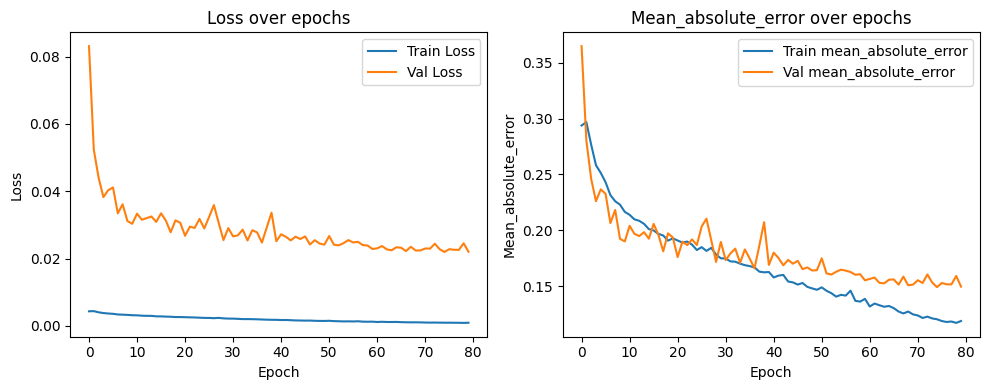

In [27]:
class DummyHistory:
    def __init__(self, history):
        self.history = history

plot_learning_curves(DummyHistory(full_history), 'mean_absolute_error')

In [28]:
results_df_cnn, mse, mae, r2 = evaluate_regression_model(cnn_model, X_test_cnn, y_test)

165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0209 - mean_absolute_error: 0.1459
Test Loss (MSE): 0.02203
Test MAE: 0.14979
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Regression Metrics:
Mean Squared Error (MSE): 0.04596
Mean Absolute Error (MAE): 0.14979
R² Score: 0.69872


In [12]:
# ✅ Сохраняем веса в HDF5 формате
cnn_model.save_weights("models/RA_predictor/RA_predictor_1.weights.h5", save_format="h5")

### Старое

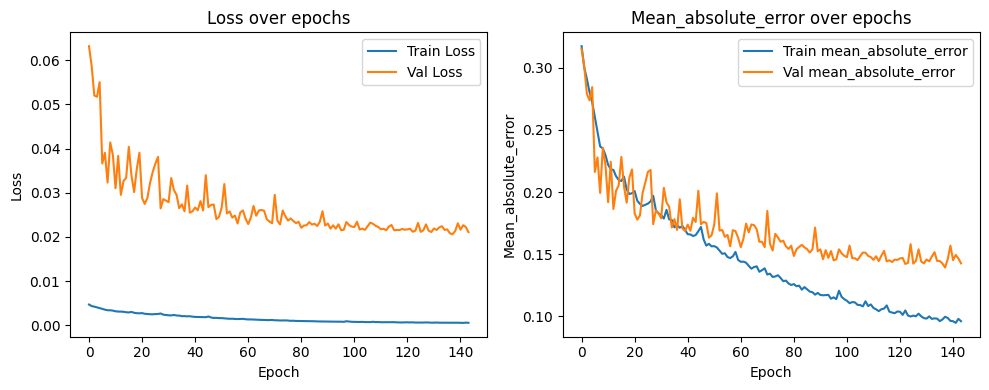

In [17]:
# Теперь можно передать в функцию
plot_learning_curves(type("History", (object,), {"history": full_history}), 'mean_absolute_error')

In [ ]:
results_df_cnn, mse, mae, r2 = evaluate_regression_model(cnn_model, X_test_cnn, y_test)

165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0201 - mean_absolute_error: 0.1374
Test Loss (MSE): 0.02110
Test MAE: 0.14253
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Regression Metrics:
Mean Squared Error (MSE): 0.04406
Mean Absolute Error (MAE): 0.14253
R² Score: 0.71119


In [ ]:
results_df_cnn.to_csv("cnn_predictions.csv", index=False)